In [57]:
#Import Libraries
import tensorflow as tf
import numpy as np #Linear Algebra
import matplotlib.pyplot as plt #Data visualization
import pandas as pd #data manipulation

import warnings
warnings.filterwarnings('ignore') #Ignore warnings

#Make sure Tensorflow is version 2.0 or higher
print('Tensorflow Version:', tf.__version__)

Tensorflow Version: 2.10.0


In [58]:
#Reads in Pollution csv
stock = pd.read_csv("E:\Coding\MachineLearning\CSVFile\VNI.csv",
                       parse_dates=['Date'],
                       index_col='Date')

stock.drop(['High', 'Open', 'Low', 'Vol.', 'Change %'], axis=1, inplace=True, errors='ignore')
stock = stock.sort_index()
stock

test = pd.read_csv("E:\Coding\MachineLearning\CSVFile\VNItest.csv",
                       parse_dates=['Date'],
                       index_col='Date')
test.drop(['High', 'Open', 'Low', 'Vol.', 'Change %'], axis=1, inplace=True, errors='ignore')
test = test.sort_index()
test

,Price
Date,
2022-08-01,"1,231.35"
2022-08-02,"1,241.62"
2022-08-03,"1,249.76"
2022-08-04,"1,254.15"
2022-08-05,"1,252.74"
...,...
2022-10-25,997.70
2022-10-26,993.36
2022-10-27,"1,028.01"


In [59]:
#Checks for and imputes missing dates
range = pd.date_range(start="2021-07-01", end="2021-12-31", freq="D") #continous dates
#stock.index #our time series
diff_dates = range.difference(stock.index) # finds what in 'a' is not in 'b'
diff_dates


DatetimeIndex(['2021-07-03', '2021-07-04', '2021-07-10', '2021-07-11',
               '2021-07-17', '2021-07-18', '2021-07-24', '2021-07-25',
               '2021-07-31', '2021-08-01', '2021-08-07', '2021-08-08',
               '2021-08-14', '2021-08-15', '2021-08-21', '2021-08-22',
               '2021-08-28', '2021-08-29', '2021-09-02', '2021-09-03',
               '2021-09-04', '2021-09-05', '2021-09-11', '2021-09-12',
               '2021-09-18', '2021-09-19', '2021-09-25', '2021-09-26',
               '2021-10-02', '2021-10-03', '2021-10-09', '2021-10-10',
               '2021-10-16', '2021-10-17', '2021-10-23', '2021-10-24',
               '2021-10-30', '2021-10-31', '2021-11-06', '2021-11-07',
               '2021-11-13', '2021-11-14', '2021-11-20', '2021-11-21',
               '2021-11-27', '2021-11-28', '2021-12-04', '2021-12-05',
               '2021-12-11', '2021-12-12', '2021-12-18', '2021-12-19',
               '2021-12-25', '2021-12-26'],
              dtype='datetime64[n

In [60]:
stock =stock.reindex(range)

In [61]:
stock['Price'].fillna(method='ffill', inplace=True)

In [62]:
stock

,Price
2021-07-01,"1,417.08"
2021-07-02,"1,420.27"
2021-07-03,"1,420.27"
2021-07-04,"1,420.27"
2021-07-05,"1,411.13"
...,...
2021-12-27,"1,488.88"
2021-12-28,"1,494.39"
2021-12-29,"1,485.82"
2021-12-30,"1,485.97"


In [63]:
stock["Price"] = stock["Price"].str.replace(',', '').astype(float)
test["Price"] = test["Price"].str.replace(',', '').astype(float)

In [64]:
stock.sort_index(inplace=True)
#sets the time index frequency as daily
stock.freq = "D"

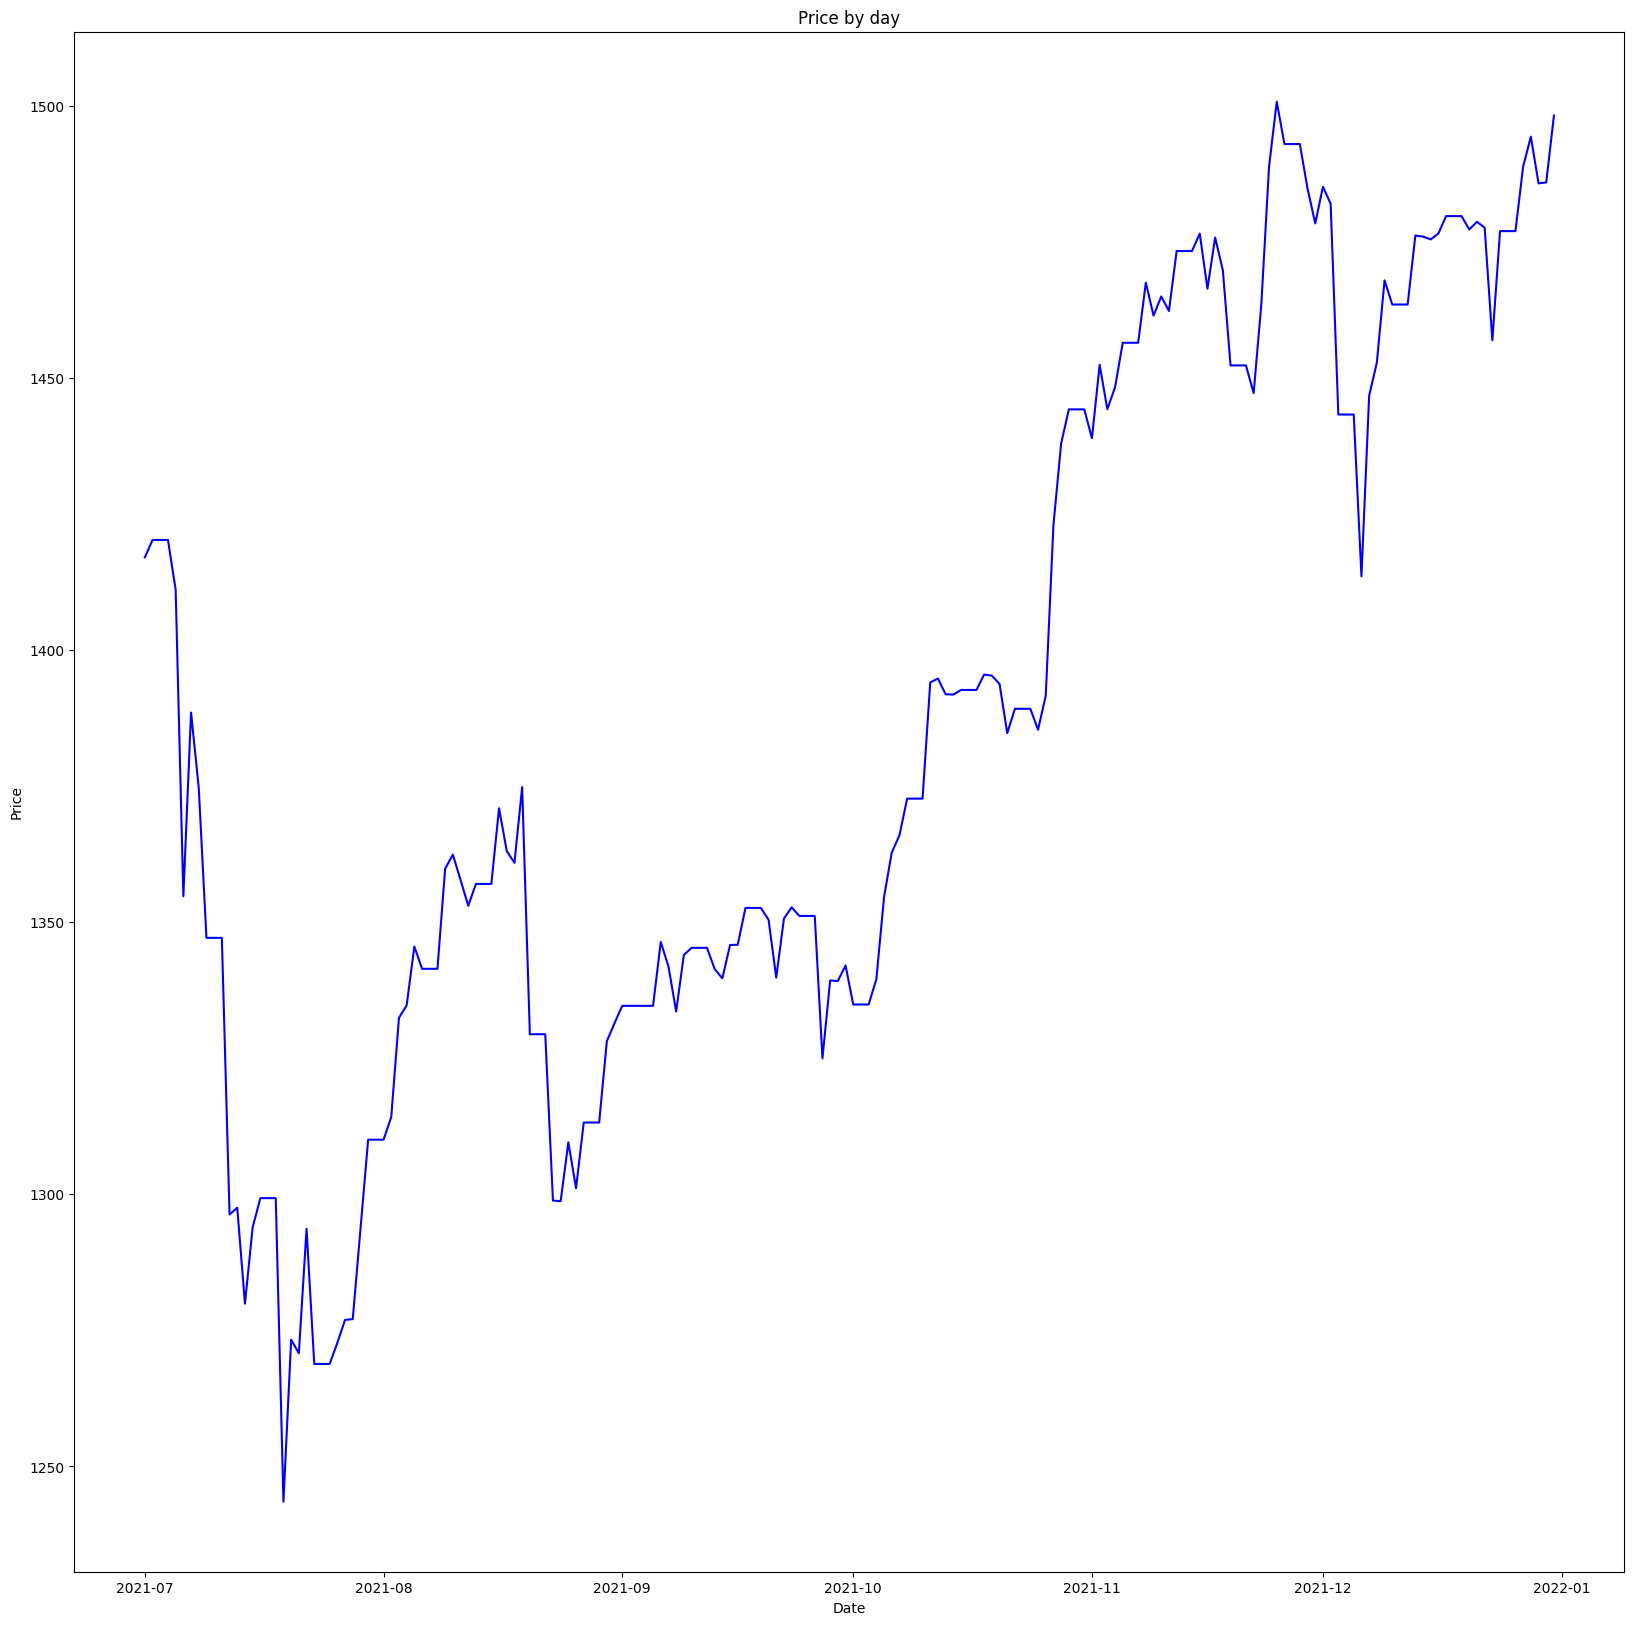

In [65]:
#displays a plot 
fig = plt.figure(figsize=(20,20))
plt.plot(stock, color='blue')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Price by day')
plt.show()

In [66]:
#Split the time series data into a train and test set
# end_train_ix = pd.to_datetime('2021-10-30')
# train = stock[:end_train_ix] 
# test = stock[end_train_ix:] 

In [67]:
train = stock
test

,Price
Date,
2022-08-01,1231.35
2022-08-02,1241.62
2022-08-03,1249.76
2022-08-04,1254.15
2022-08-05,1252.74
...,...
2022-10-25,997.70
2022-10-26,993.36
2022-10-27,1028.01


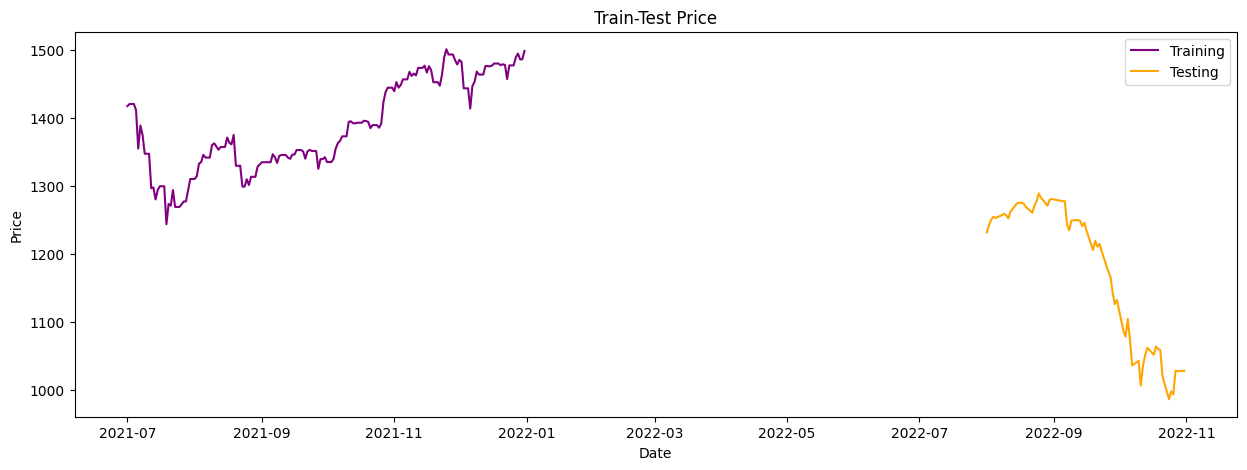

In [68]:
#displays a plot of the train/test split
fig = plt.figure(figsize=(15,5))
plt.plot(train, color='purple', label='Training')
plt.plot(test, color='orange', label='Testing')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Train-Test Price')
plt.legend()
plt.show()

In [69]:
#Creates a windowed dataset from the time series data
WINDOW = 14 #the window value... 14 days

#converts values to TensorSliceDataset
train_data = tf.data.Dataset.from_tensor_slices(train.values) 

#takes window size + 1 slices of the dataset
train_data = train_data.window(WINDOW+1, shift=1, drop_remainder=True)

#flattens windowed data by batching 
train_data = train_data.flat_map(lambda x: x.batch(WINDOW+1))

#creates features and target tuple
train_data = train_data.map(lambda x: (x[:-1], x[-1]))

#shuffles dataset
# train_data = train_data.shuffle(1_000)

#creates batches of windows
train_data = train_data.batch(45).prefetch(1)

In [70]:
# A callback can be executed at a number of specific intances during model training.
from tensorflow.keras.callbacks import Callback

class CustomCallback(Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('mae') < 10.0:
            print("MAE under 10.0... Stopping training")
            self.model.stop_training = True

my_callback = CustomCallback()

# stop the model from training once the model reaches under 10 mean absolute error on the training set.

In [71]:
from tensorflow.keras.callbacks import LearningRateScheduler

#creates a function that updates the learning rate based on the epoch number
def scheduler(epoch, lr):
    if epoch < 2:
        return 0.01
    else:
        return lr * 0.99

lr_scheduler = LearningRateScheduler(scheduler)

### LSTM

In [72]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Lambda, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import Huber

# model = Sequential()
# model.add(LSTM(50, return_sequences=True, input_shape=[WINDOW]))
# model.add(Dropout(0.2))
# model.add(LSTM(50, return_sequences=True))
# model.add(Dropout(0.2))
# model.add(LSTM(50, return_sequences=True))
# model.add(Dropout(0.2))
# model.add(LSTM(50, return_sequences=False))
# model.add(Dropout(0.2))
# model.add(Dense(1))



# hist = model.fit(train_data, batch_size=32, epochs=50)

lstm_model = Sequential([
    # add extra axis to input data
    Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[WINDOW]), 
    Bidirectional(LSTM(128, return_sequences=True)),
    Bidirectional(LSTM(128)),
    Dense(256, activation='relu'),
    Dropout(0.4),
    Dense(1)
])

lstm_model.compile(
    loss=Huber(),
    optimizer=Adam(learning_rate=0.0001),
    metrics=['mae']
)

# model.compile(loss='mean_squared_error',optimizer="Adam")

lstm_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_6 (Lambda)           (None, 14, 1)             0         
                                                                 
 bidirectional_8 (Bidirectio  (None, 14, 256)          133120    
 nal)                                                            
                                                                 
 bidirectional_9 (Bidirectio  (None, 256)              394240    
 nal)                                                            
                                                                 
 dense_12 (Dense)            (None, 256)               65792     
                                                                 
 dropout_10 (Dropout)        (None, 256)               0         
                                                                 
 dense_13 (Dense)            (None, 1)                

In [73]:
#Trains LSTM Model
lstm_history = lstm_model.fit(
    train_data,
    batch_size = 30,
    epochs=100,
    callbacks=[lr_scheduler, my_callback],
    verbose=1
)

Epoch 1/100
4/4 [==============================] - 9s 268ms/step - loss: 1374.1621 - mae: 1374.6624 - lr: 0.0100
Epoch 2/100
4/4 [==============================] - 1s 263ms/step - loss: 1306.3561 - mae: 1306.8558 - lr: 0.0100
Epoch 3/100
4/4 [==============================] - 1s 293ms/step - loss: 1188.1123 - mae: 1188.6123 - lr: 0.0099
Epoch 4/100
4/4 [==============================] - 1s 298ms/step - loss: 1022.2280 - mae: 1022.7280 - lr: 0.0098
Epoch 5/100
4/4 [==============================] - 1s 287ms/step - loss: 792.1028 - mae: 792.6028 - lr: 0.0097
Epoch 6/100
4/4 [==============================] - 1s 301ms/step - loss: 482.6218 - mae: 483.1218 - lr: 0.0096
Epoch 7/100
4/4 [==============================] - 1s 332ms/step - loss: 149.0339 - mae: 149.5337 - lr: 0.0095
Epoch 8/100
4/4 [==============================] - 2s 393ms/step - loss: 213.4945 - mae: 213.9945 - lr: 0.0094
Epoch 9/100
4/4 [==============================] - 1s 336ms/step - loss: 288.1629 - mae: 288.6629 - lr: 

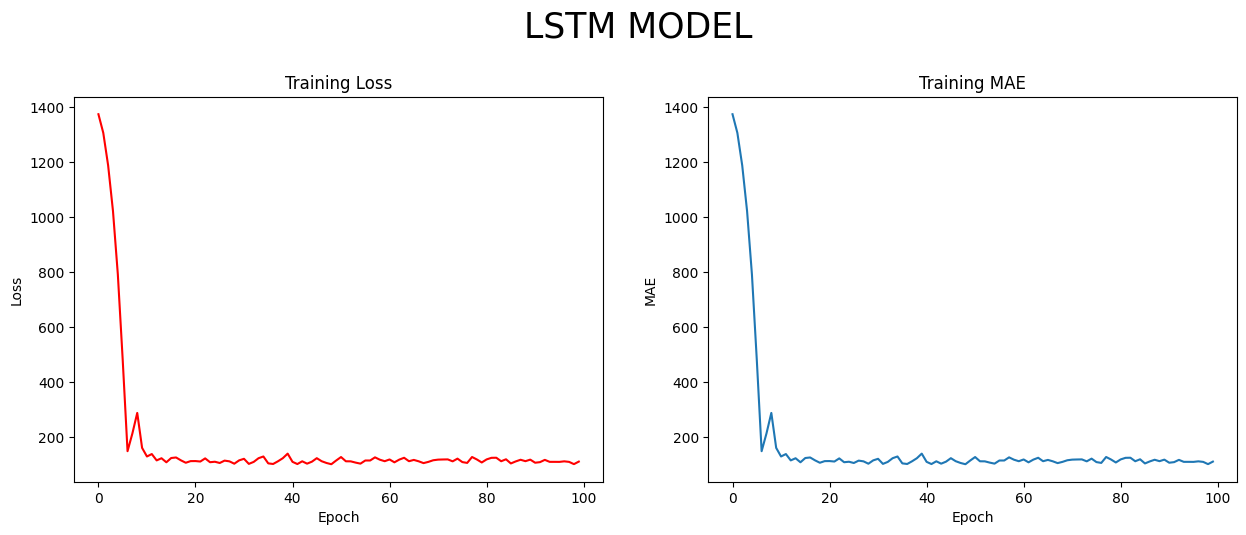

					FINAL LOSS: 111.14 | FINAL MAE: 111.64


In [74]:
#plots training history
#Plots history of model training
plt.rcParams["figure.figsize"] = (15,5)
fig, axs = plt.subplots(1, 2)

axs[0].plot(lstm_history.history['loss'], color='red')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].set_title('Training Loss')

axs[1].plot(lstm_history.history['mae'])
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('MAE')
axs[1].set_title('Training MAE')

fig.text(0.425,1, 'LSTM MODEL', {'size':25})
plt.show()

print("\t\t\t\t\tFINAL LOSS: {} | FINAL MAE: {}".format(
                                                round(lstm_history.history['loss'][-1], 2),
                                                 round(lstm_history.history['mae'][-1] ,2)))

### CNN

In [75]:
from tensorflow.keras.layers import Conv1D, GlobalAveragePooling1D, Flatten


cnn_model = Sequential([
    # add extra axis to input data
    Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[WINDOW]),
    Conv1D(filters=32, kernel_size=3, strides=1,
           padding='causal', activation='relu'),
    Conv1D(filters=64, kernel_size=3, strides=1, 
           padding='causal', activation='relu'),
    GlobalAveragePooling1D(),
    Flatten(),
    Dropout(0.3),
    Dense(512, activation='relu'),
    Dropout(0.4),
    Dense(1)
])

cnn_model.compile(
    loss=Huber(),
    optimizer=Adam(learning_rate=0.0001),
    metrics=['mae']
)

cnn_model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_7 (Lambda)           (None, 14, 1)             0         
                                                                 
 conv1d_6 (Conv1D)           (None, 14, 32)            128       
                                                                 
 conv1d_7 (Conv1D)           (None, 14, 64)            6208      
                                                                 
 global_average_pooling1d_2   (None, 64)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 flatten_2 (Flatten)         (None, 64)                0         
                                                                 
 dropout_11 (Dropout)        (None, 64)                0         
                                                      

In [76]:
#Trains CNN Model
cnn_history = cnn_model.fit(
    train_data,
    epochs=100,
    callbacks=[lr_scheduler, my_callback],
    verbose=1
)

Epoch 1/100
4/4 [==============================] - 1s 23ms/step - loss: 783.3275 - mae: 783.8275 - lr: 0.0100
Epoch 2/100
4/4 [==============================] - 0s 30ms/step - loss: 253.7757 - mae: 254.2757 - lr: 0.0100
Epoch 3/100
4/4 [==============================] - 0s 14ms/step - loss: 199.9635 - mae: 200.4635 - lr: 0.0099
Epoch 4/100
4/4 [==============================] - 0s 10ms/step - loss: 188.9007 - mae: 189.4007 - lr: 0.0098
Epoch 5/100
4/4 [==============================] - 0s 10ms/step - loss: 172.6611 - mae: 173.1611 - lr: 0.0097
Epoch 6/100
4/4 [==============================] - 0s 9ms/step - loss: 169.4989 - mae: 169.9984 - lr: 0.0096
Epoch 7/100
4/4 [==============================] - 0s 9ms/step - loss: 155.6460 - mae: 156.1450 - lr: 0.0095
Epoch 8/100
4/4 [==============================] - 0s 9ms/step - loss: 177.4115 - mae: 177.9115 - lr: 0.0094
Epoch 9/100
4/4 [==============================] - 0s 9ms/step - loss: 189.7995 - mae: 190.2995 - lr: 0.0093
Epoch 10/100
4

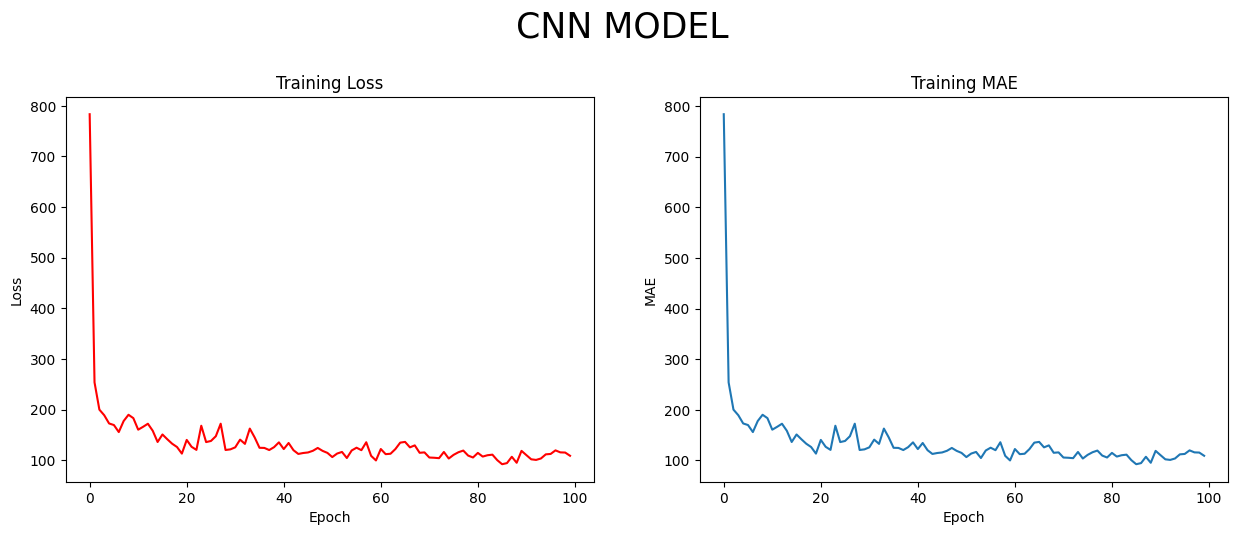

					FINAL LOSS: 108.84 | FINAL MAE: 109.34


In [77]:
#plots training history
#Plots history of model training
plt.rcParams["figure.figsize"] = (15,5)
fig, axs = plt.subplots(1, 2)

axs[0].plot(cnn_history.history['loss'], color='red')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].set_title('Training Loss')

axs[1].plot(cnn_history.history['mae'])
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('MAE')
axs[1].set_title('Training MAE')

fig.text(0.425,1, 'CNN MODEL', {'size':25})
plt.show()

print("\t\t\t\t\tFINAL LOSS: {} | FINAL MAE: {}".format(
                                                round(cnn_history.history['loss'][-1], 2),
                                                 round(cnn_history.history['mae'][-1], 2)))

### Mixed Architecture Model

In [78]:
mixed_model = Sequential([
    # add extra axis to input data
    Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[WINDOW]),
    Conv1D(filters=64, kernel_size=3, strides=1,
           padding='causal', activation='relu'),
    Bidirectional(LSTM(128, return_sequences=True)),
    Bidirectional(LSTM(128)),
    Dropout(0.3),
    Dense(512, activation='relu'),
    Dropout(0.4),
    Dense(1)
])


mixed_model.compile(
    loss=Huber(),
    optimizer=Adam(learning_rate=0.0001),
    metrics=['mae']
)

mixed_model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_8 (Lambda)           (None, 14, 1)             0         
                                                                 
 conv1d_8 (Conv1D)           (None, 14, 64)            256       
                                                                 
 bidirectional_10 (Bidirecti  (None, 14, 256)          197632    
 onal)                                                           
                                                                 
 bidirectional_11 (Bidirecti  (None, 256)              394240    
 onal)                                                           
                                                                 
 dropout_13 (Dropout)        (None, 256)               0         
                                                                 
 dense_16 (Dense)            (None, 512)              

In [79]:
#Trains Mixed Model
mixed_history = mixed_model.fit(
    train_data,
    epochs=100,
    callbacks=[lr_scheduler, my_callback],
    verbose=1
)

Epoch 1/100
4/4 [==============================] - 7s 323ms/step - loss: 1356.0867 - mae: 1356.5867 - lr: 0.0100
Epoch 2/100
4/4 [==============================] - 1s 320ms/step - loss: 1190.4484 - mae: 1190.9484 - lr: 0.0100
Epoch 3/100
4/4 [==============================] - 1s 323ms/step - loss: 882.8273 - mae: 883.3273 - lr: 0.0099
Epoch 4/100
4/4 [==============================] - 1s 320ms/step - loss: 404.4346 - mae: 404.9346 - lr: 0.0098
Epoch 5/100
4/4 [==============================] - 1s 320ms/step - loss: 144.7399 - mae: 145.2399 - lr: 0.0097
Epoch 6/100
4/4 [==============================] - 1s 314ms/step - loss: 251.3695 - mae: 251.8695 - lr: 0.0096
Epoch 7/100
4/4 [==============================] - 1s 317ms/step - loss: 153.1788 - mae: 153.6774 - lr: 0.0095
Epoch 8/100
4/4 [==============================] - 1s 316ms/step - loss: 174.0243 - mae: 174.5243 - lr: 0.0094
Epoch 9/100
4/4 [==============================] - 1s 320ms/step - loss: 90.7924 - mae: 91.2909 - lr: 0.0093

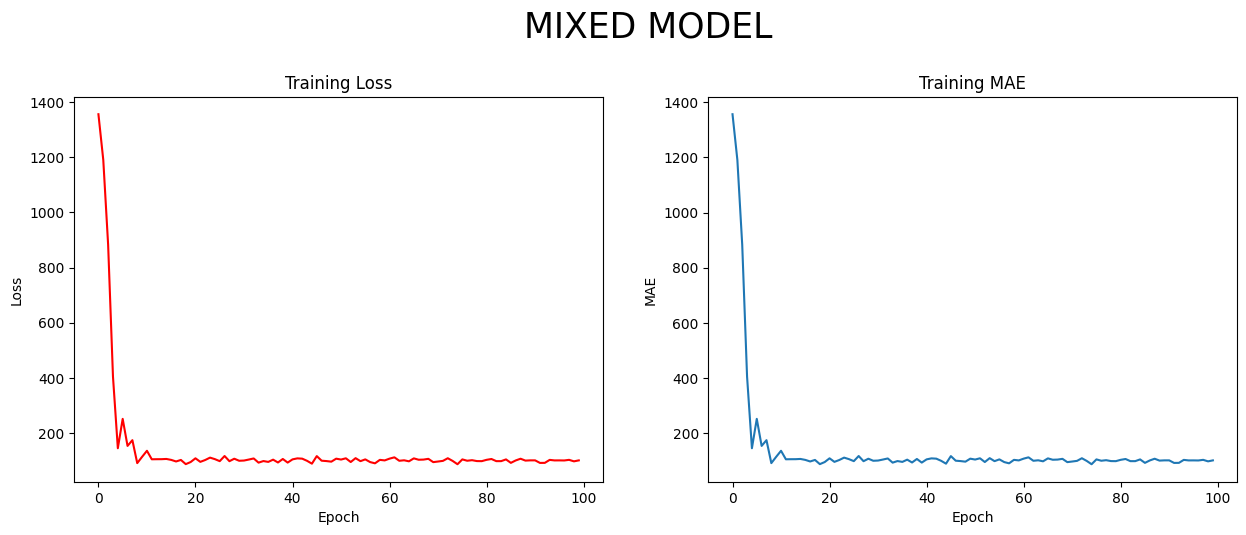

					FINAL LOSS: 100.73 | FINAL MAE: 101.23


In [80]:
#plots training history
#Plots history of model training
plt.rcParams["figure.figsize"] = (15,5)
fig, axs = plt.subplots(1, 2)

axs[0].plot(mixed_history.history['loss'], color='red')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].set_title('Training Loss')

axs[1].plot(mixed_history.history['mae'])
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('MAE')
axs[1].set_title('Training MAE')

fig.text(0.425,1, 'MIXED MODEL', {'size':25})
plt.show()

print("\t\t\t\t\tFINAL LOSS: {} | FINAL MAE: {}".format(
                                                round(mixed_history.history['loss'][-1], 2),
                                                 round(mixed_history.history['mae'][-1], 2)))

### Evaluate Models on Test Set

In [81]:
#Gets forecasts of models

all_models = [('LSTM MODEL', lstm_model),
              ('CNN MODEL', cnn_model),
              ('MIXED MODEL', mixed_model)]

model_forecasts = {
    'LSTM MODEL': [],
    'CNN MODEL': [],
    'MIXED MODEL': []
}

#chunck of data to be windowed so that each window associated to a value in test set
forecast_data = train[-WINDOW:].append(test[:-1]).values

for name, model in all_models:
    #converts values to TensorSliceDataset
    test_data = tf.data.Dataset.from_tensor_slices(forecast_data) 
    #takes window size  slices of the dataset
    test_data = test_data.window(WINDOW, shift=1, drop_remainder=True)
    #flattens windowed data by batching 
    test_data = test_data.flat_map(lambda x: x.batch(WINDOW+1))
    #creates batches of windows
    test_data = test_data.batch(32).prefetch(1)
    #gets model prediction 
    preds = model.predict(test_data)
    #append to forecast dict
    model_forecasts[name].append(preds)

2/2 [==============================] - 2s 72ms/step


In [82]:
#Gets MAE score of model forecasts

N = test.values.shape[0] #number of samples in test set

lstm_mae = np.abs(test.values - model_forecasts['LSTM MODEL'][0].squeeze()).sum() / N

cnn_mae = np.abs(test.values - model_forecasts['CNN MODEL'][0].squeeze()).sum() / N

mix_mae = np.abs(test.values - model_forecasts['MIXED MODEL'][0].squeeze()).sum() / N


print('MODEL MAE SCORES')
print('=====================================')
print('LSTM MAE:', round(lstm_mae, 2))
print('CNN MAE:', round(cnn_mae, 2))
print('MIXED MAE:', round(mix_mae, 2))

MODEL MAE SCORES
LSTM MAE: 12323.12
CNN MAE: 17557.17
MIXED MAE: 14430.75


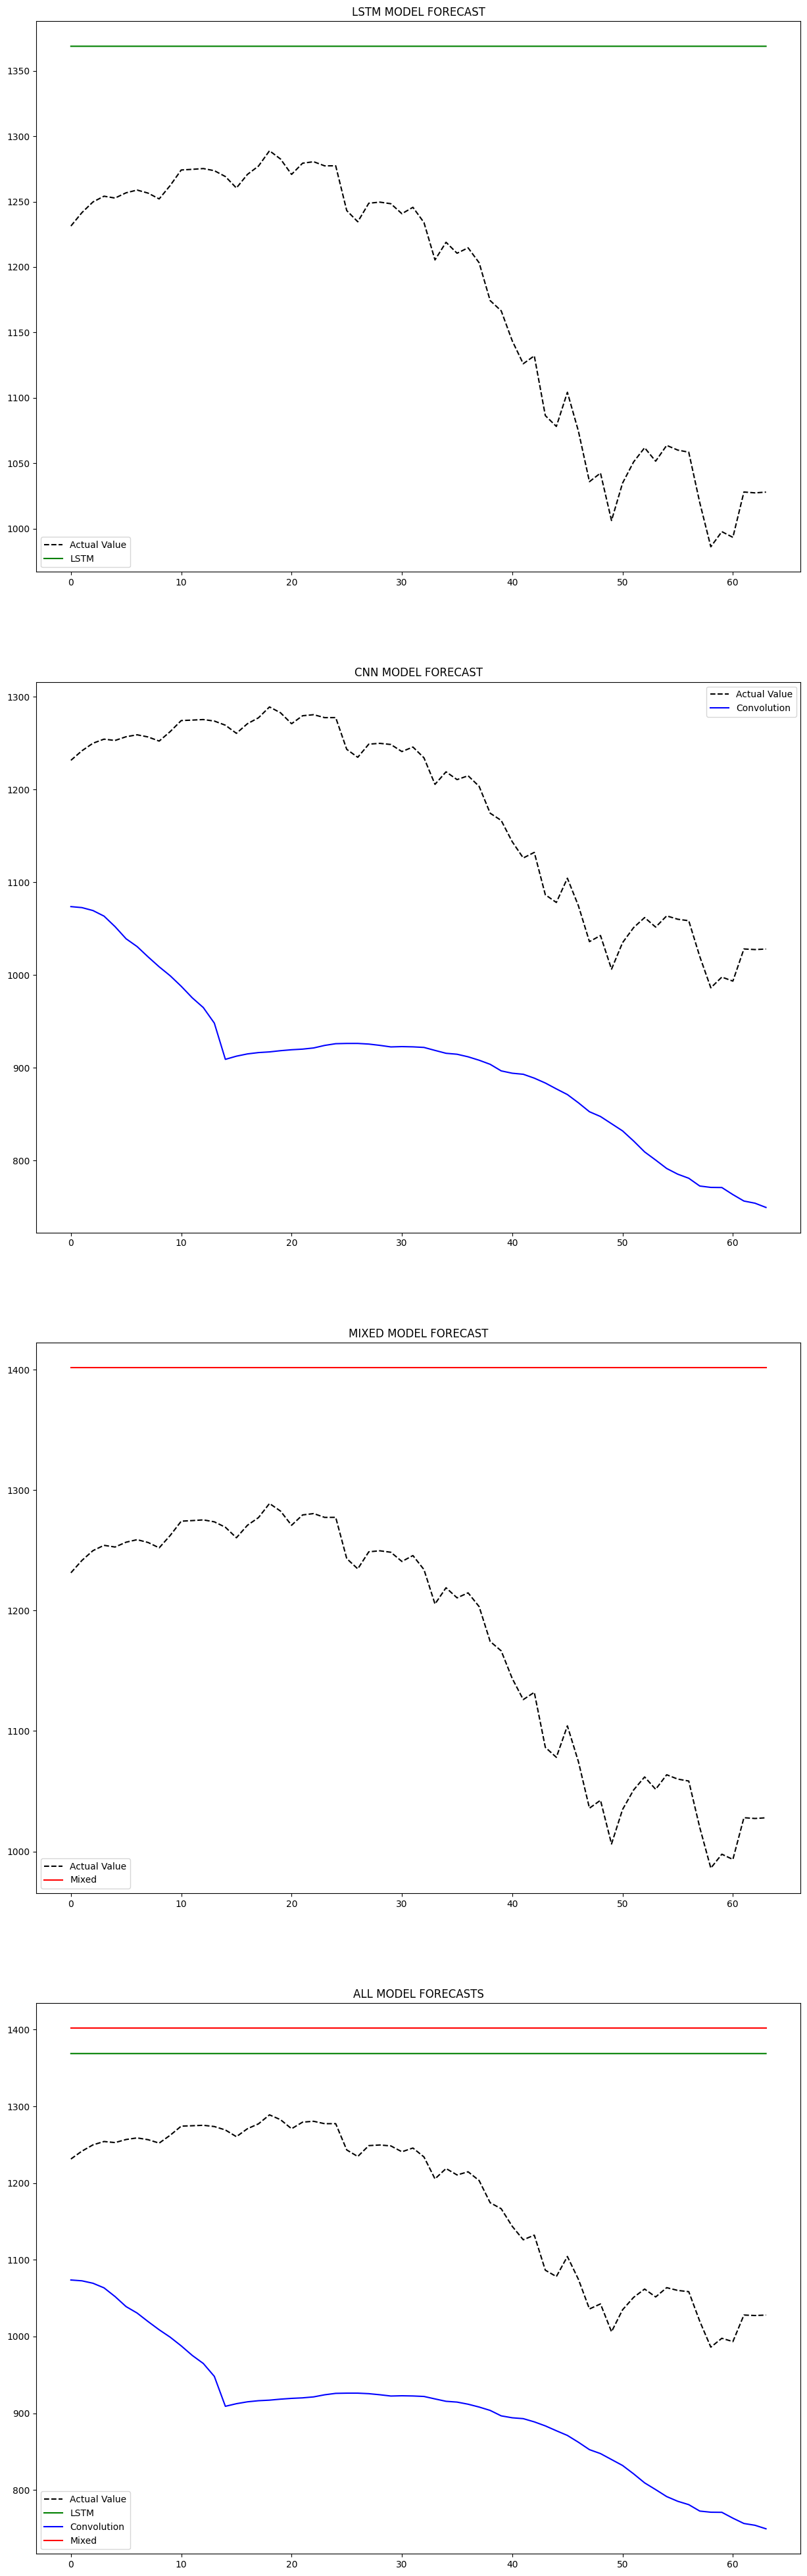

In [83]:
#displays forecasted data
plt.rcParams["figure.figsize"] = (15,50)
fig, axs = plt.subplots(4, 1)

#LSTM Forecast
axs[0].plot(test.values, color='black', linestyle='--', label='Actual Value')
axs[0].plot(model_forecasts['LSTM MODEL'][0].squeeze(), color='green', label='LSTM')
axs[0].set_title('LSTM MODEL FORECAST')
axs[0].legend()

#CNN Forcast
axs[1].plot(test.values, color='black', linestyle='--', label='Actual Value')
axs[1].plot(model_forecasts['CNN MODEL'][0].squeeze(), color='blue', label='Convolution')
axs[1].set_title('CNN MODEL FORECAST')
axs[1].legend()

#Mixed Model Forecast
axs[2].plot(test.values, color='black', linestyle='--', label='Actual Value')
axs[2].plot(model_forecasts['MIXED MODEL'][0].squeeze(), color='red', label='Mixed')
axs[2].set_title('MIXED MODEL FORECAST')
axs[2].legend()

#All forecasts
axs[3].plot(test.values, color='black', linestyle='--', label='Actual Value')
axs[3].plot(model_forecasts['LSTM MODEL'][0].squeeze(), color='green', label='LSTM')
axs[3].plot(model_forecasts['CNN MODEL'][0].squeeze(), color='blue', label='Convolution')
axs[3].plot(model_forecasts['MIXED MODEL'][0].squeeze(), color='red', label='Mixed')
axs[3].set_title('ALL MODEL FORECASTS')
axs[3].legend()


plt.show()